# Fullscan Renders
Outputting the graphs of the data collected by running the robot :) This notebook is for viewing the fullscan data, as well as trying to reproduce a mathematical model of the relationship between the transducer pulser and it's position/rotation.

### Import relevant modules

In [172]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import pandas as pd
import sys
from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 2

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

%matplotlib inline
# %matplotlib widget
# %pylab

from fit_funcs import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Check for available files

In [173]:
path = os.path.abspath('..\\')
print("Available test files:")
file_itr = 0
while os.path.exists(path + "\\Scans\\test_%s.json" % file_itr):
    print("\t\\Scans\\test_%s.json" % file_itr)
    file_itr +=1
file_itr = 0
while os.path.exists(path + "\\Debugging Scripts\\Scans\\test_%s.json" % file_itr):
    print("\t\\Debugging Scripts\\Scans\\test_%s.json" % file_itr)
    file_itr +=1

Available test files:
	\Scans\test_0.json
	\Scans\test_1.json
	\Scans\test_2.json
	\Scans\test_3.json
	\Scans\test_4.json
	\Scans\test_5.json
	\Scans\test_6.json
	\Scans\test_7.json
	\Scans\test_8.json
	\Scans\test_9.json
	\Scans\test_10.json
	\Scans\test_11.json
	\Scans\test_12.json
	\Scans\test_13.json
	\Scans\test_14.json
	\Scans\test_15.json
	\Scans\test_16.json
	\Scans\test_17.json
	\Scans\test_18.json
	\Scans\test_19.json
	\Scans\test_20.json
	\Debugging Scripts\Scans\test_0.json
	\Debugging Scripts\Scans\test_1.json
	\Debugging Scripts\Scans\test_2.json


### Select appropriate file and output options
Debug mode prints more information to the notebook, save_figs outputs the relevant figures to a designated folder, and file_no specifices which scan file should be used.

In [174]:
debug_mode = True
save_figs = False
file_no = 6

if save_figs:
    plt.rcParams['figure.dpi'] = 500
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Palatino"],
    })
else:
    plt.rcParams['figure.dpi'] = 200

In [175]:
# current_file = r"\Debugging Scripts\test_%s.json" % file_no
current_file = r"\Scans\test_%s.json" % file_no
path = os.path.abspath('..\\') + current_file

if debug_mode:
    print(path)

with open(path, 'r') as infile:
    json_data = json.load(infile)

print(json_data.keys())

r_o_m = json_data["range of motion"]
# resolution = json_data["resolution"]
points = json_data["points"]
max_point = json_data["max_point"]


if debug_mode:
    for i in json_data.keys():
        if i != "points":
            print(f"{i}: {json_data[i]}")
        else:
            print(f"{i}: {json_data[i][0]}")


c:\Users\ander\OneDrive - UW\Robotics lab material\Robotics Control Code\Ben's Control Code\Scans\test_6.json
dict_keys(['range of motion', 'resolution', 'max_point', 'points', 'notes', 'active_ROM'])
range of motion: {'X': [0, 0], 'Y': [0, 0], 'Z': [-14, 14], 'Rx': [-13, 13], 'Ry': [-13, 13], 'Rz': [0, 0]}
resolution: [0.4, 1]
max_point: [0.0, 0.0, 2.400000000000002, 0.0, 1.0, 0.0, 621.204]
points: [-14.0, -13.0, -12.0, 216.071]
notes: This is a recreation of test_6.json, I first need to verify that the transition worked before this file will replace that one.
Fullscan version of a pathfinder module, scans the entire search-space at a fixed resolution.
	Range of motion: {'X': [0, 0], 'Y': [0, 0], 'Z': [-14, 14], 'Rx': [-13, 13], 'Ry': [-13, 13], 'Rz': [0, 0]}
	Resolution: (0.4, 1)
	Highest magnitude found: [  0.      0.      2.4     0.      1.      0.    621.204]
active_ROM: ['Z', 'Rx', 'Ry']


### Parse data into a pandas DataFrame

In [176]:
np_all = np.array(points)
active_rom = json_data["active_ROM"]
cols = active_rom.copy()
cols.append("mag")
# need to test my git profile
dat = pd.DataFrame(data = np_all, columns=cols)

mp = dat.loc[dat['mag'].idxmax()]

if debug_mode:
    print(mp)
    print(dat.head())
    print(dat.shape)

Z        2.400
Rx       0.000
Ry       1.000
mag    621.204
Name: 30246, dtype: float64
      Z    Rx    Ry      mag
0 -14.0 -13.0 -12.0  216.071
1 -14.0 -13.0 -11.0   39.674
2 -14.0 -13.0 -10.0   39.674
3 -14.0 -13.0  -9.0   39.674
4 -14.0 -13.0  -8.0   39.674
(51749, 4)


### First Figure, all data

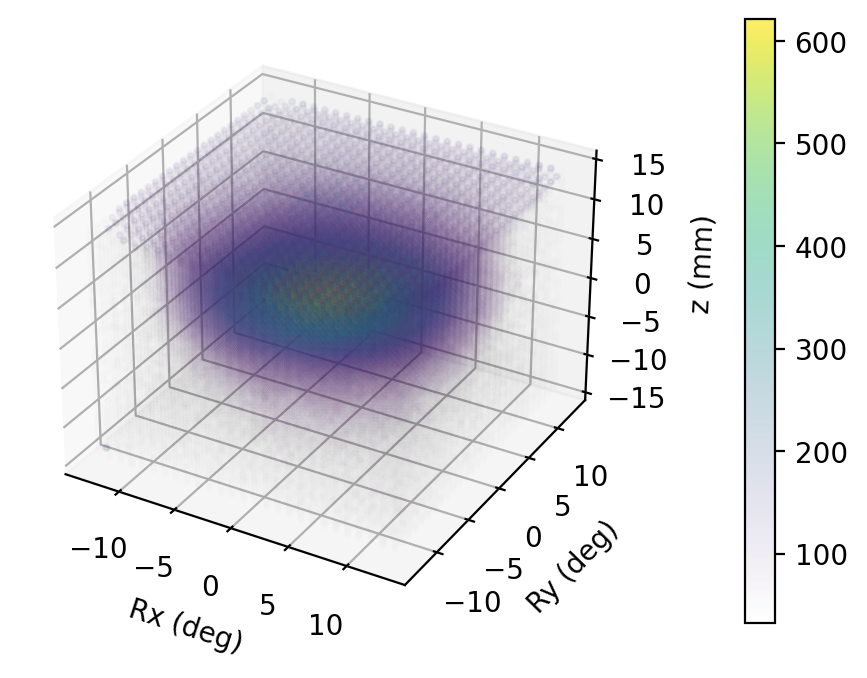

Maximum magnitude:  621.204
Minimum magnitude: 32.197
Median magnitude: 47.151
621.204


In [202]:
ax = plt.axes(projection='3d')

med = np.median(dat['mag'])
dat2 = dat[dat['mag'] > med*2]

# Choose colormap
cmap = plt.cm.viridis

# Get the colormap colors
my_cmap = cmap(np.arange(cmap.N))
# Set alpha
my_cmap[:,-1] = np.linspace(0, 1, cmap.N)*0.7
# Create new colormap
my_cmap = ListedColormap(my_cmap)


# fig = ax.scatter(dat2['Rx'], dat2['Ry'], dat2['Z'], c=dat2['mag'], cmap='viridis', alpha=0.1,s=1)
fig = ax.scatter(dat['Rx'], dat['Ry'], dat['Z'], c=dat['mag'], cmap=my_cmap,s=4)

ax.set_xlabel("Rx (deg)")
ax.set_ylabel("Ry (deg)")
ax.set_zlabel("z (mm)")

plt.colorbar(fig, pad=0.13)
if save_figs:
    plt.savefig("figures\\fullscan_render_test_%s.jpg" % file_no, dpi=400)
plt.show()

if debug_mode:
    print(f"Maximum magnitude:  {max(dat['mag'])}")
    print(f"Minimum magnitude: {min(dat['mag'])}")
    print(f"Median magnitude: {med}")
    print(max(dat['mag']))
    
    # print((min(dat2['Rx']),max(dat2['Rx'])))
    # print((min(dat2['Ry']),max(dat2['Ry'])))
    # print((min(dat2['Z']),max(dat2['Z'])))

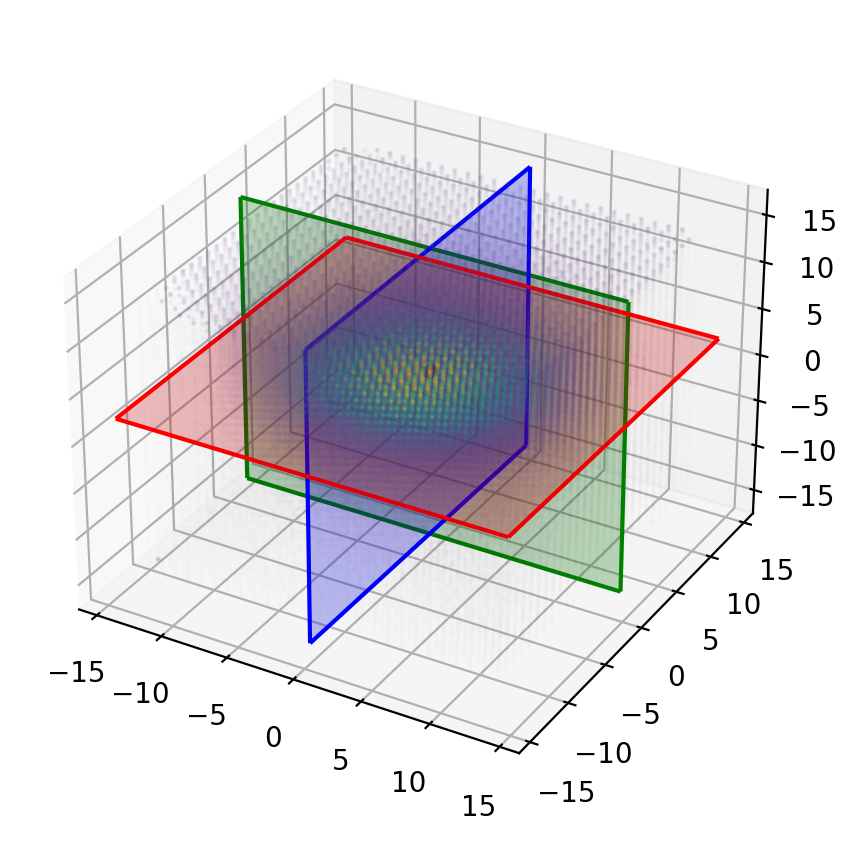

In [193]:
fig = plt.figure(figsize=(4,4), constrained_layout=True)
ax = fig.add_subplot(projection='3d')

ax.scatter(dat['Rx'], dat['Ry'], dat['Z'], c=dat['mag'], cmap=my_cmap,s=1)
ax.scatter(mp['Rx'], mp['Ry'], mp['Z'], color='r')

alpha = 0.25
xlim = ax.get_xlim()
ylim = ax.get_ylim()
zlim = ax.get_zlim()

X,Y = np.meshgrid(xlim,ylim)
Z = np.ones(X.shape)*mp['Z']
ax.plot_surface(X=X, Y=Y, Z=Z, color='r', alpha=alpha)
ax.plot_wireframe(X=X, Y=Y, Z=Z, color='r')
# Slice through the Rx-Z plane with maximum Ry
X,Z = np.meshgrid(xlim,zlim)
Y = np.ones(Y.shape)*mp['Ry']
ax.plot_surface(X=X, Y=Y, Z=Z, color='g', alpha=alpha)
ax.plot_wireframe(X=X, Y=Y, Z=Z, color='g')
# Slice through the Rx-Ry plane with maximum Z
Z,Y = np.meshgrid(zlim,ylim)
X = np.ones(X.shape)*mp['Rx']
ax.plot_surface(X=X, Y=Y, Z=Z, color='b', alpha=alpha)
ax.plot_wireframe(X=X, Y=Y, Z=Z, color='b')

# plt.savefig("figures\\data_slice1_%s.jpg" % file_no, dpi=400)

In [194]:
# "mps" stands for "max points," or all the points in Rx/Ry space that occur at the max
# value of Z, rotated for each of the other dimensions
# mp = max_point[0]

zmps = dat[dat['Z'] == mp['Z']]
Rxmps = dat[dat['Rx'] == mp['Rx']]
Rymps = dat[dat['Ry'] == mp['Ry']]
med = np.median(dat['mag'])

if debug_mode:
    print(f"Active range of motion: {active_rom}")
    print(f"Shape of point/mags array: {np_all.shape}")
    print(f"Tenth point_mag item (representative): {np_all[10]}")
    print(f"Testing the Z-max-points array:\n{zmps.head(4)}\n(Should be all the same as in the maxpoint)")
    print(f"Maximum point: {mp}")

# foo_isolated_mps refers to the points along the isolated foo axis when the other axes are at their optimal values
z_isolated_mps = dat[np.all([dat['Rx'] == mp['Rx'], dat['Ry'] == mp['Ry']],axis=0)].reset_index(drop=True)
Rx_isolated_mps = dat[np.all([dat['Z'] == mp['Z'], dat['Ry'] == mp['Ry']],axis=0)].reset_index(drop=True)
Ry_isolated_mps = dat[np.all([dat['Z'] == mp['Z'], dat['Rx'] == mp['Rx']],axis=0)].reset_index(drop=True)

if debug_mode:
    print(Ry_isolated_mps.head())
    # print(Rx_isolated_mps)
    # print(Ry_isolated_mps)
    pass

Active range of motion: ['Z', 'Rx', 'Ry']
Shape of point/mags array: (51749, 4)
Tenth point_mag item (representative): [-14.    -13.     -2.     37.233]
Testing the Z-max-points array:
         Z    Rx    Ry     mag
29881  2.4 -13.0  13.0  37.233
29882  2.4 -13.0  12.0  37.233
29883  2.4 -13.0  11.0  34.639
29884  2.4 -13.0  10.0  34.639
(Should be all the same as in the maxpoint)
Maximum point: Z        2.400
Rx       0.000
Ry       1.000
mag    621.204
Name: 30246, dtype: float64
     Z   Rx    Ry      mag
0  2.4  0.0 -13.0   47.151
1  2.4  0.0 -12.0   47.151
2  2.4  0.0 -11.0   66.988
3  2.4  0.0 -10.0   91.861
4  2.4  0.0  -9.0  121.769


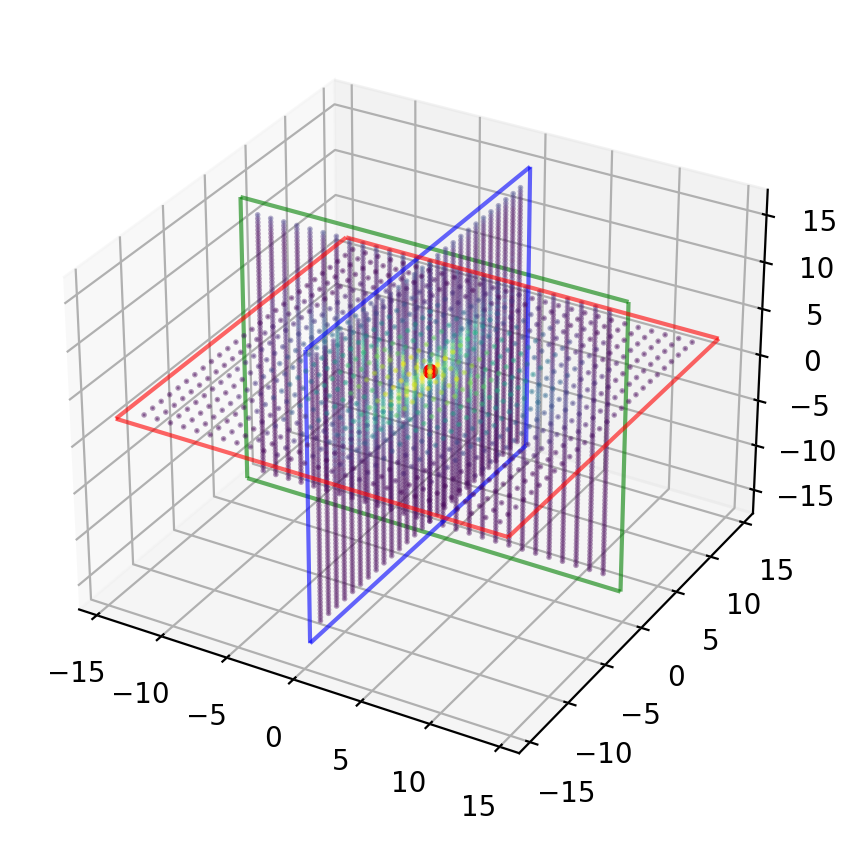

In [180]:
fig = plt.figure(figsize=(4,4), constrained_layout=True)
ax = fig.add_subplot(projection='3d')

# ax.scatter(dat2['Rx'], dat2['Ry'], dat2['Z'], c=dat2['mag'], cmap='viridis', alpha=0.2,s=1)
# ax.scatter(dat['Rx'], dat['Ry'], dat['Z'], c=dat['mag'], cmap='viridis', alpha=0.005)#,s=9)
ax.scatter(zmps['Rx'], zmps['Ry'], np.ones(zmps['Ry'].shape)* mp['Z'], c=zmps['mag'], cmap='viridis', alpha=0.4,s=1)
ax.scatter(np.ones(Rxmps['Ry'].shape)* mp['Rx'], Rxmps['Ry'], Rxmps['Z'], c=Rxmps['mag'], cmap='viridis', alpha=0.4,s=1)
ax.scatter(Rymps['Rx'], np.ones(Rymps['Ry'].shape)* mp['Ry'], Rymps['Z'], c=Rymps['mag'], cmap='viridis', alpha=0.4,s=1)
ax.scatter(mp['Rx'], mp['Ry'], mp['Z'], color='r')
# tax.scatter3D(zmps['Rx'], zmps['Ry'], zmps['mag'],c=zmps['mag'], cmap='viridis',s=4)

xlim = ax.get_xlim()
ylim = ax.get_ylim()
zlim = ax.get_zlim()

alpha = 0.6
# Slice through the Rx-Ry plane with maximum Z
X,Y = np.meshgrid(xlim,ylim)
Z = np.ones(X.shape)*mp['Z']
ax.plot_wireframe(X=X, Y=Y, Z=Z, color='r', alpha=alpha)
# Slice through the Rx-Z plane with maximum Ry
X,Z = np.meshgrid(xlim,zlim)
Y = np.ones(X.shape)*mp['Ry']
ax.plot_wireframe(X=X, Y=Y, Z=Z, color='g', alpha=alpha)
# Slice through the Rx-Ry plane with maximum Z
Z,Y = np.meshgrid(zlim,ylim)
X = np.ones(X.shape)*mp['Rx']
ax.plot_wireframe(X=X, Y=Y, Z=Z, color='b', alpha=alpha)

# plt.savefig("figures\\data_slice2_%s.jpg" % file_no, dpi=400)

In [181]:
x = np.arange(-5,5,0.1)
y = np.arange(-5,5,0.1)
X,Y = np.meshgrid(x,y)
Z = X*np.exp(-X**2 - Y**2)

print(X.shape)
print(Y.shape)
print(Z.shape)
print(X)
print(Z)

(100, 100)
(100, 100)
(100, 100)
[[-5.  -4.9 -4.8 ...  4.7  4.8  4.9]
 [-5.  -4.9 -4.8 ...  4.7  4.8  4.9]
 [-5.  -4.9 -4.8 ...  4.7  4.8  4.9]
 ...
 [-5.  -4.9 -4.8 ...  4.7  4.8  4.9]
 [-5.  -4.9 -4.8 ...  4.7  4.8  4.9]
 [-5.  -4.9 -4.8 ...  4.7  4.8  4.9]]
[[-9.64374924e-22 -2.54345186e-21 -6.57255648e-21 ...  1.66406660e-20
   6.57255648e-21  2.54345186e-21]
 [-2.59535904e-21 -6.84502532e-21 -1.76882906e-20 ...  4.47839341e-20
   1.76882906e-20  6.84502532e-21]
 [-6.84641300e-21 -1.80567966e-20 -4.66607281e-20 ...  1.18137531e-19
   4.66607281e-20  1.80567966e-20]
 ...
 [-1.77028362e-20 -4.66896334e-20 -1.20651095e-19 ...  3.05469355e-19
   1.20651095e-19  4.66896334e-20]
 [-6.84641300e-21 -1.80567966e-20 -4.66607281e-20 ...  1.18137531e-19
   4.66607281e-20  1.80567966e-20]
 [-2.59535904e-21 -6.84502532e-21 -1.76882906e-20 ...  4.47839341e-20
   1.76882906e-20  6.84502532e-21]]


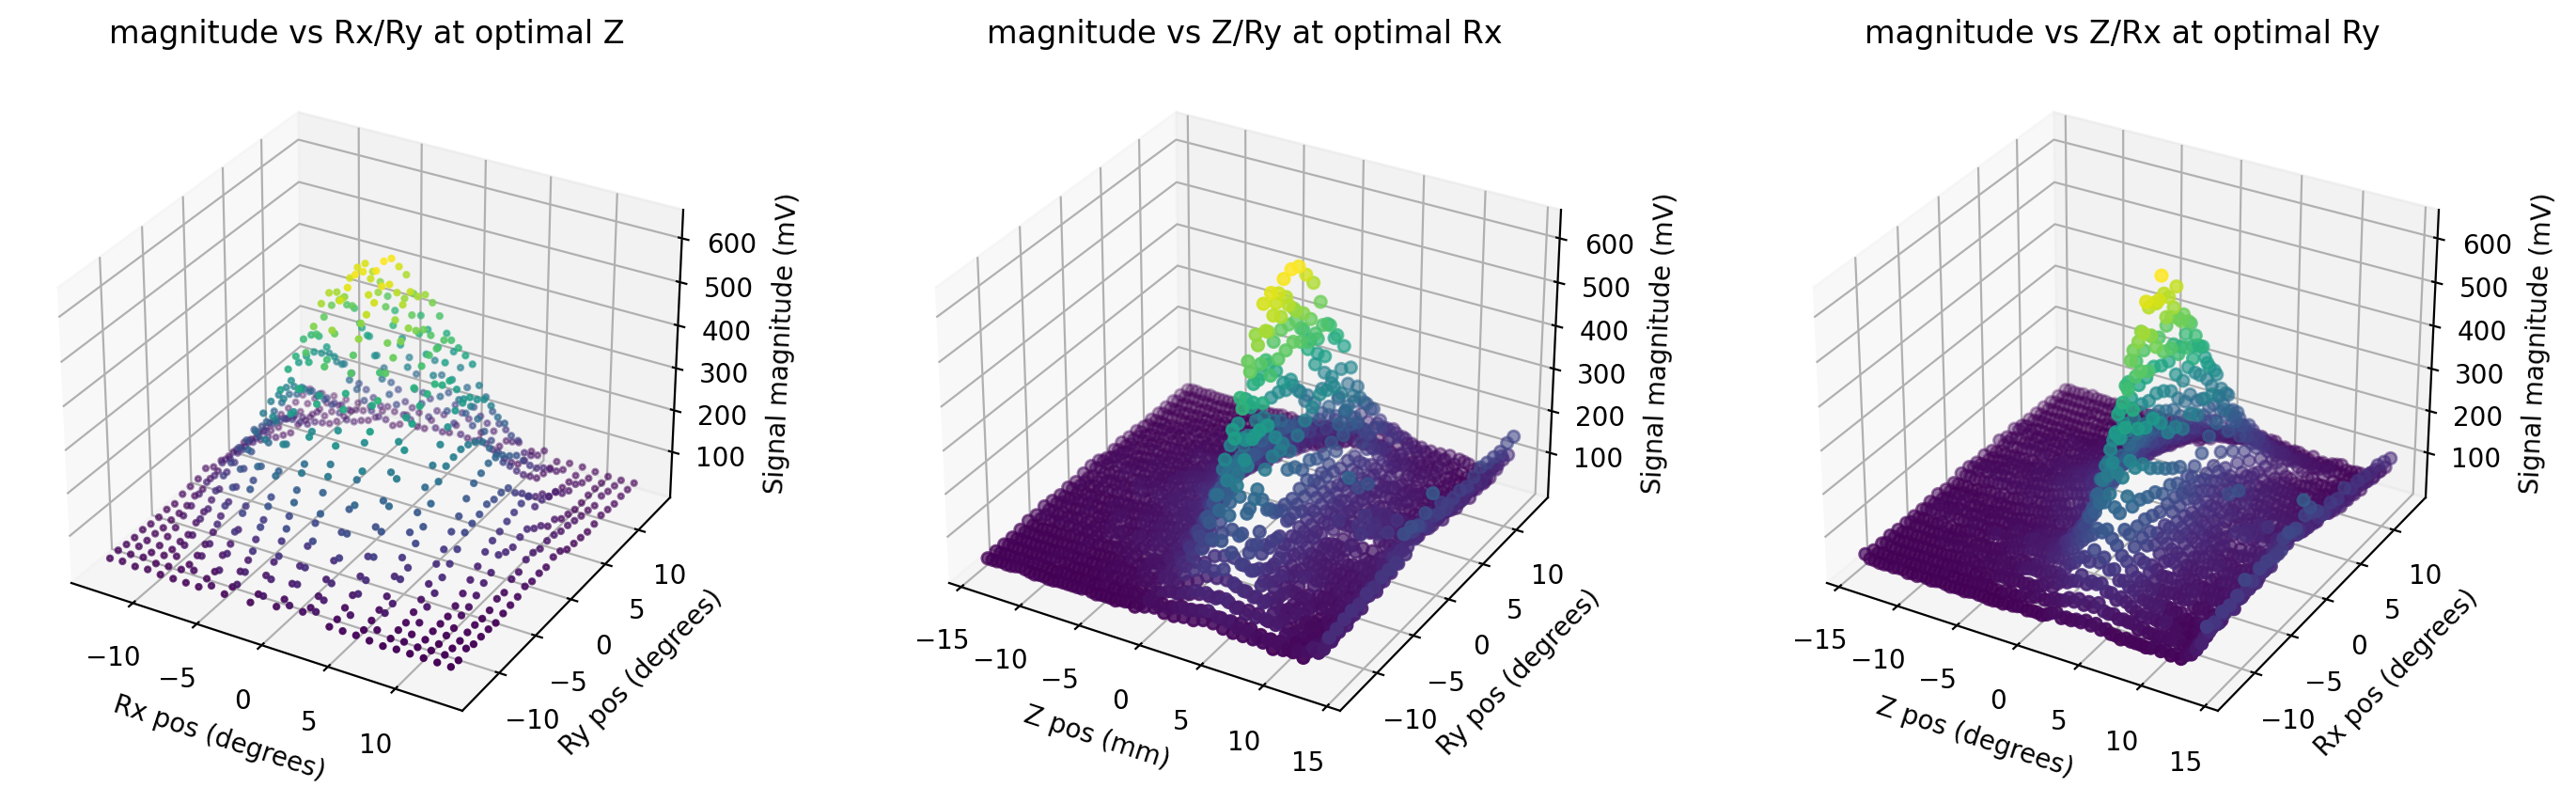

In [182]:
fig2 = plt.figure(figsize=(14,4), constrained_layout=True)
# tax = plt.figure()
# tax = plt.axes(projection="3d")

tax = fig2.add_subplot(1,3,1, projection='3d')
# tax = plt.axes(projection='3d')
tax.scatter3D(zmps['Rx'], zmps['Ry'], zmps['mag'],c=zmps['mag'], cmap='viridis',s=4)
# tax.plot3D(Rx_isolated_mps['Rx'], Rx_isolated_mps['Ry'], Rx_isolated_mps['mag'], c='g')
# tax.plot3D(Ry_isolated_mps['Rx'], Ry_isolated_mps['Ry'], Ry_isolated_mps['mag'], c='b')
tax.set_title("magnitude vs Rx/Ry at optimal Z")
tax.set_xlabel("Rx pos (degrees)")
tax.set_ylabel("Ry pos (degrees)")
tax.set_zlabel("Signal magnitude (mV)")



tax = fig2.add_subplot(1,3,2, projection='3d')
tax.scatter(Rxmps['Z'], Rxmps['Ry'], Rxmps['mag'],c=Rxmps['mag'], cmap='viridis')
# tax.plot3D(z_isolated_mps[:,0], z_isolated_mps[:,2], z_isolated_mps[:,3], c='r')
# tax.plot3D(Ry_isolated_mps[:,0], Ry_isolated_mps[:,2], Ry_isolated_mps[:,3], c='b')
tax.set_title("magnitude vs Z/Ry at optimal Rx")
tax.set_xlabel("Z pos (mm)")
tax.set_ylabel("Ry pos (degrees)")
tax.set_zlabel("Signal magnitude (mV)")

tax = fig2.add_subplot(1,3,3, projection='3d')
# tax.plot_trisurf(Rymps[:,0], Rymps[:,1], Rymps[:,3], cmap='viridis')
tax.scatter(Rymps['Z'], Rymps['Rx'], Rymps['mag'],c=Rymps['mag'], cmap='viridis')
# tax.plot3D(z_isolated_mps[:,0], z_isolated_mps[:,1], z_isolated_mps[:,3], c='r')
# tax.plot3D(Rx_isolated_mps[:,0], Rx_isolated_mps[:,1], Rx_isolated_mps[:,3], c='g')
tax.set_title("magnitude vs Z/Rx at optimal Ry")
tax.set_xlabel("Z pos (degrees)")
tax.set_ylabel("Rx pos (degrees)")
tax.set_zlabel("Signal magnitude (mV)")

if save_figs:
    plt.savefig("figures\\Isolated_axes_w_trace_%s.jpg" % file_no, dpi=400)
plt.show()

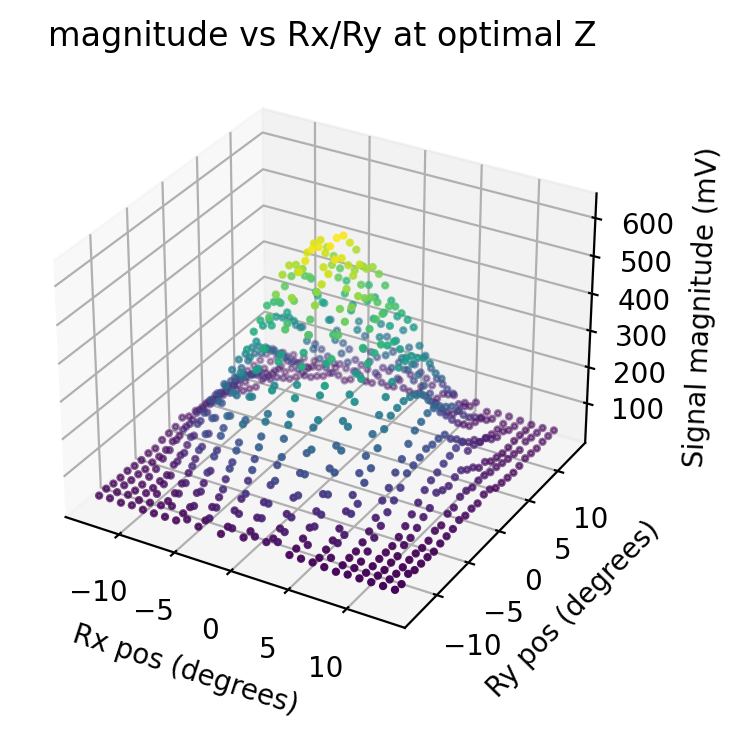

In [183]:
fig2 = plt.figure(figsize=(5,4), constrained_layout=False)
tax = fig2.add_subplot(projection='3d')

tax.scatter3D(zmps['Rx'], zmps['Ry'], zmps['mag'],c=zmps['mag'], cmap='viridis',s=4)
# tax.plot3D(Rx_isolated_mps['Rx'], Rx_isolated_mps['Ry'], Rx_isolated_mps['mag'], c='g')
# tax.plot3D(Ry_isolated_mps['Rx'], Ry_isolated_mps['Ry'], Ry_isolated_mps['mag'], c='b')
tax.set_title("magnitude vs Rx/Ry at optimal Z")
tax.set_xlabel("Rx pos (degrees)")
tax.set_ylabel("Ry pos (degrees)")
tax.set_zlabel("Signal magnitude (mV)")
plt.savefig("figures\\Isolated_axes_1_%s.jpg" % file_no, dpi=400)

Guess: [800, 0.1, 1, 1.0, 2.400000000000002, 47.151]
Fin: [780.2798, 0.0101, 1.2534, 0.1889, 2.5136, 29.6092]
R2: 0.8576796465671424


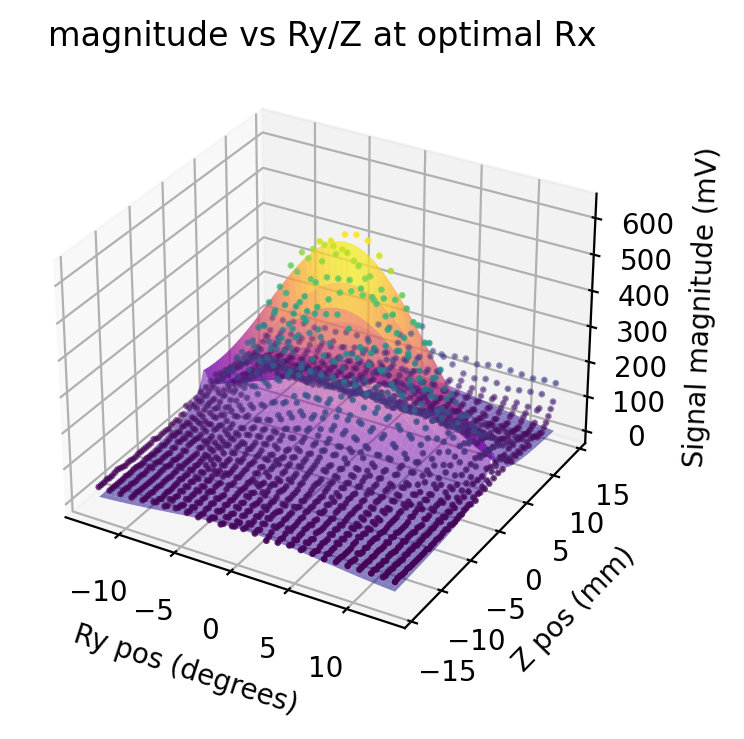

In [184]:
# (X,Y,Z,title,xlable,ylable,guess) = (zmps['Rx'],zmps['Ry'],zmps['mag'],"magnitude vs Ry/Rx at optimal Z","Rx pos (degrees)","Ry pos (degrees)",[600,60,mp['Rx'],mp['Ry'],med])
(X,Y,Z,title,xlable,ylable,guess) = (Rxmps['Ry'],Rxmps['Z'],Rxmps['mag'],"magnitude vs Ry/Z at optimal Rx","Ry pos (degrees)","Z pos (mm)",[800,0.1,1,mp['Ry'],mp['Z'],med])
# (X,Y,Z,title,xlable,ylable,guess) = (Rymps['Ry'],Rymps['Z'],Rymps['mag'],"magnitude vs Rx/Z at optimal Ry","Z pos (mm)","Rx pos (degrees)",[1,1,1,1,mp['Z'],mp['Ry'],med])

popt, pcov = curve_fit(ang_plus_z, [X, Y], Z,p0=guess,maxfev=5000)
# popt, pcov = curve_fit(double_ang,[X,Y],Z)
# print(popt)
print(f"Guess: {guess}")
# popt, pcov = curve_fit(double_ang,[X,Y],Z,p0=guess)
print(f"Fin: {[round(i,4) for i in popt]}")
print(f"R2: {r_squared(ang_plus_z, popt, [X, Y], Z)}")


# create surface function model
# setup data points for calculating surface model
model_y_data = np.linspace(min(Y), max(Y), 100)
model_x_data = np.linspace(min(X), max(X), 100)
# create coordinate arrays for vectorized evaluations
Xs, Ys = np.meshgrid(model_x_data, model_y_data)
# calculate Z coordinate array
Zs = ang_plus_z(np.array([Xs, Ys]), *popt)


fig3 = plt.figure()

tax = plt.axes(projection="3d")
# tax = fig3.add_subplot(1,2,1, projection='3d')

tax.scatter3D(X,Y,Z,cmap='viridis',c=Z,s=2)
tax.set_title(title)
tax.set_xlabel(xlable)
tax.set_ylabel(ylable)
tax.set_zlabel("Signal magnitude (mV)")
# tax.axis("off")
tax.plot_surface(Xs,Ys,Zs, cmap='plasma',alpha=0.5)
# tax.view_init(0,0)

# tax2 = fig3.add_subplot(1,2,2, projection='3d')

# tax2.scatter3D(X,Y,Z,cmap='viridis',c=Z,s=2)
# # tax2.set_title(title)
# # tax.set_xlabel(xlable)
# # tax.set_ylabel(ylable)
# # tax.set_zlabel("Signal magnitude (mV)")
# tax2.axis("off")
# tax2.plot_surface(Xs,Ys,Zs, cmap='plasma',alpha=0.5)
# # tax2.view_init(0,90)


if save_figs:
    tax.get_figure().savefig("figures\\Fullscan_2d_fit_%s.jpg" % file_no, dpi=400)

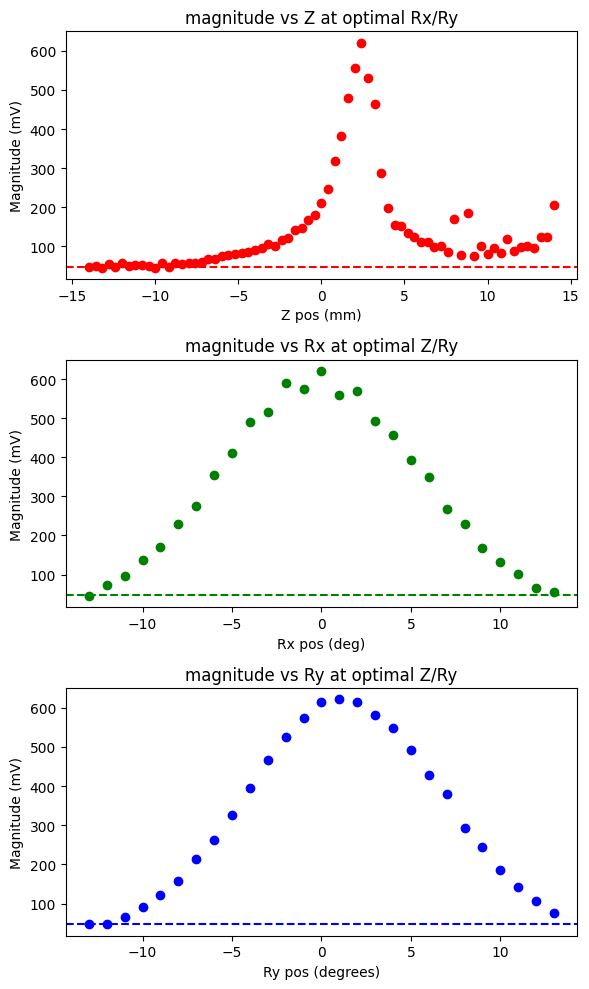

In [185]:
fig3 = plt.figure(figsize=(6,10), dpi=100)
# plt.subplots_adjust(left=0.1,
#                     bottom=0.1, 
#                     right=0.9, 
#                     top=0.9, 
#                     wspace=0.8, 
#                     hspace=0.4)


tax = fig3.add_subplot(311)
tax.scatter(z_isolated_mps['Z'],z_isolated_mps['mag'], c='r')
tax.axhline(med, c='r',ls='--')
# tax.axhline(np.median(dat['mag']), c='r',ls='--')
tax.set_title("magnitude vs Z at optimal Rx/Ry")
tax.set_xlabel("Z pos (mm)")
tax.set_ylabel("Magnitude (mV)")

tax = fig3.add_subplot(312)
tax.scatter(Rx_isolated_mps['Rx'],Rx_isolated_mps['mag'], c='g')
tax.axhline(med, c='g',ls='--')
tax.set_title("magnitude vs Rx at optimal Z/Ry") 
tax.set_xlabel("Rx pos (deg)")
tax.set_ylabel("Magnitude (mV)")

tax = fig3.add_subplot(313)
tax.scatter(Ry_isolated_mps['Ry'],Ry_isolated_mps['mag'], c='b')
tax.axhline(med, c='b',ls='--')
tax.set_title("magnitude vs Ry at optimal Z/Ry")
tax.set_xlabel("Ry pos (degrees)")
tax.set_ylabel("Magnitude (mV)")

fig3.tight_layout()

KeyError: '[70] not in index'

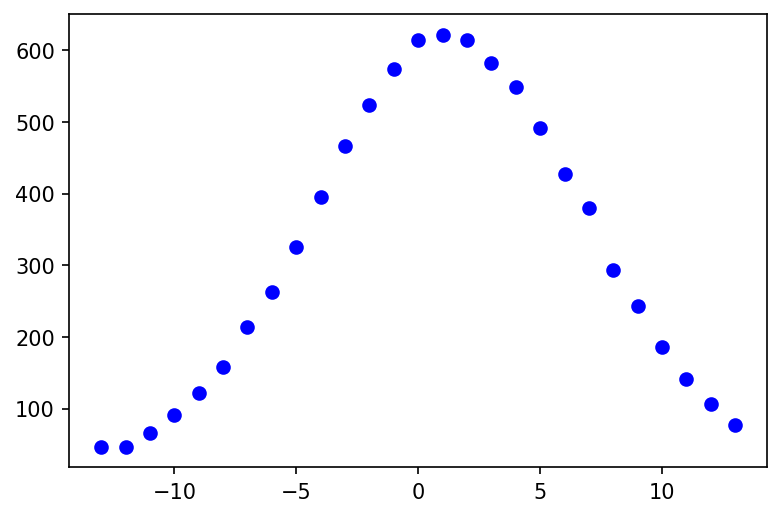

In [186]:
fig4 = plt.axes()
fig4.get_figure().dpi=150

interpolation_windows= { \
    "Z": [0,0], \
    "Rx": [0,0], \
    "Ry": [0,70]}
# interpolation_windows= { \
#     "Z": [8,56], \
#     "Rx": [0,26], \
#     "Ry": [1,26]}
# interpolation_windows= { \
#     "Z": [8,40], \
#     "Rx": [0,26], \
#     "Ry": [1,26]}

t = {'Z': {'data': z_isolated_mps, 'color1': 'r', 'noise': med, 'color2':'g', \
    'header':'magnitude vs Z at optimal Rx/Ry', 'x-axis': "Z pos (mm)"}, \
    'Rx': {'data': Rx_isolated_mps, 'color1': 'g', 'noise': med, 'color2':'b', \
    'header':'magnitude vs Rx at optimal Z/Ry', 'x-axis': "Rx ang (deg)"}, \
    'Ry': {'data': Ry_isolated_mps, 'color1':'b', 'noise': med, 'color2':'r', \
    'header':'magnitude vs Ry at optimal Z/Rx', 'x-axis':"Ry ang (deg)"}}

b = 'Ry'
a = interpolation_windows[b]

funcs = [(polynomial_2,[1,1,1]),
        (rational_2,[1,1,1,1]),
        (inv_absolute,[1,1,mp[b],med]),
        (gauss,[1,1,mp[b],med])]


fig4.scatter(t[b]['data'][b],t[b]['data']['mag'], c=t[b]['color1'])
fig4.scatter(t[b]['data'][b][a],t[b]['data']['mag'][a], c=t[b]['color2'], marker='*')
fig4.axhline(t[b]['noise'], c='g',ls='--')

# x = np.linspace(t[b]['data'][b][a[0]],t[b]['data'][b][a[1]],500)
x = np.linspace(min(t[b]['data'][b]),max(t[b]['data'][b]),500)

x_data = t[b]['data'][b]#[a[0]:a[1]]
y_data = t[b]['data']['mag']#[a[0]:a[1]]

for (fun,guess) in funcs:
    try:
        popt, pcov = curve_fit(fun, x_data, y_data,p0=guess)
        print(f"{fun.__doc__}: {popt}")
        R2 = r_squared(fun, popt, x_data, y_data)
        if R2 > 0:
            fig4.plot(x, fun(x, *popt), label=fun.__doc__ + f"\n R2={R2:0.3f}")
    except RuntimeError as e:
        print(f"{fun.__doc__} couldn't converge.")

fig4.set_title(t[b]['header'])
fig4.set_xlabel(t[b]['x-axis'])
fig4.set_ylabel("Magnitude (mV)")
fig4.legend(prop={'size':6})
fig4.set_ybound([0, t[b]['data']['mag'].max() * 1.2])

In [ ]:
# Time to fit,,, all the fucking data

Z=dat["Z"]
Rx=dat["Rx"]
Ry=dat["Ry"]
mag=dat["mag"]

# # Arguments arrangement: double_ang_1, double_ang_2, inv_absolute_1, inv_absolute_2, Rx_offset, Ry_offset, z_offset, magnitude_offset
guess = [1000,60,1,1,mp['Rx'],mp['Ry'],mp['Z'],med]
print(guess)
# bounds = (np.array([0,0,-100,-10,mp['Rx']-0.5,mp['Ry']-0.5,mp['Z']-0.5,med-10]),
#         np.array([50000000,80,100,10,mp['Rx']+0.5,mp['Ry']+0.5,mp['Z']+0.5,med+10]))

# popt, pcov = curve_fit(Z_Rx_Ry,[Z,Rx,Ry],mag,p0=guess,bounds=bounds,maxfev=5000)
popt, pcov = curve_fit(Z_Rx_Ry,[Z,Rx,Ry],mag,p0=guess,maxfev=10000)
print(popt)


print("R2 value")
print(r_squared(Z_Rx_Ry, popt, [Z,Rx,Ry], mag))

[1000, 60, 1, 1, -1.7000000000000004, -3.800000000000002, 2.2999999999999994, 379.65]


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.

In [ ]:
a = ['2022-01-01 00:07:52.943',
    '2022-01-01 00:09:31.745',
    '2022-01-01 01:12:37.187',
    '2022-01-01 02:45:42.834',
    '2022-01-01 02:56:58.152']

df = pd.DataFrame(data=a)
print(df.head())

df.index = pd.to_datetime(df[0])

b = df.resample('H').count()[0]
print('---------------')
print(b)

                         0
0  2022-01-01 00:07:52.943
1  2022-01-01 00:09:31.745
2  2022-01-01 01:12:37.187
3  2022-01-01 02:45:42.834
4  2022-01-01 02:56:58.152
---------------
0
2022-01-01 00:00:00    2
2022-01-01 01:00:00    1
2022-01-01 02:00:00    2
Freq: H, Name: 0, dtype: int64


In [ ]:
point = ((1,2,3),(4,5,6),7)
a = np.array(point[0])
a = np.append(a,point[1])
a = np.append(a,point[2])
print(a)

[1 2 3 4 5 6 7]
